# 母婴商品销售数据分析

## 项目介绍

#### 项目背景
根据PEST框架，从四个角度简要分析：

政策Politics：国家发展改革委2013年5月28日表示，13个部门将出台系列政策措施，从可信交易、移动支付、网络电子发票、商贸流通和物流配送共5个方面支持电子商务发展，有利于促进在线母婴商品市场快速发展。

经济Economy：随着国内经济的稳定增长，2015年我国城镇居民可支配收入增长到31195元， 同期农村居民可支配收入增长到11422元。不断提高的人均可支配收入将提升家庭的消费意愿，2015年中国母婴行业市场规模有望达到2万亿。

社会Society：对于一线城市居民来说，随时随地通过手机、电脑等电子网络设备足不出门即可完成购物的新型消费方式更能适应他们紧凑的生活节奏；而对于二三线城市以及农村居民，物流上门配送带来的便捷也使得网购更具吸引力。

技术Technology：4G网络的普及、手机和ipad等移动设备快速升级迭代更新、网络在线支付系统的发展，为电子商务迅速崛起注入强大的动力。

### 分析目的
1. 帮助在线商家针对不同的时间节点和场景做出不同的销售和运营管理策略，帮助商家提高销量和营业额、减少经营成本。
2. 根据父母的购买行为来预测孩子的年龄，或者根据孩子的信息(年龄、性别等)来预测用户会购买什么样的商品。

### 问题拆解
![](提高销售量.png)

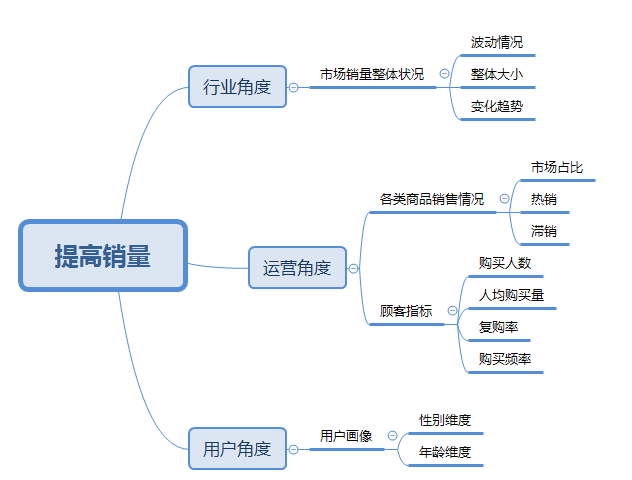

### 数据概览
Ali_Mum_Baby是一个包含超过900万儿童信息(生日和性别)的数据集，由消费者提供，他们共享这些信息是为了获得更好的推荐或搜索结果。\
数据来源:https://tianchi.aliyun.com/dataset/dataDetail?dataId=45 \
本次数据共有两个csv\
婴儿信息表

|Column|Description|
|--|--|
|user_id|user id|
|birthday|children's birthday|
|gender|0-female,1-male,2-unknown|

交易信息表

|Column|Description|
|--|--|
|item_id|item id|
|user_id|user id |
|cat_id|category id|
|cat1|root category id|
|propery|property of the corresponding item|
|buy_mount|purchase quantity|
|day|timestamp|

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyecharts.charts as pyc
import pyecharts.options as opts
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
# 作图的字体默认设置
fontdict = {'fontsize': 15,
            'horizontalalignment': 'center'}

## 数据准备

### 导入数据

In [2]:
baby = pd.read_csv(r"C:\Users\ZG\Desktop\母婴商品销量分析\sam_tianchi_mum_baby.csv")
trade = pd.read_csv(r"C:\Users\ZG\Desktop\母婴商品销量分析\sam_tianchi_mum_baby_trade_history.csv")

In [3]:
baby.head()

,user_id,birthday,gender
0,2757,20130311,1
1,415971,20121111,0
2,1372572,20120130,1
3,10339332,20110910,0
4,10642245,20130213,0


#### gender children的性别（“ 0”代表女性，“ 1”代表男性，“ 2”代表未知）。

In [4]:
trade.head()

,user_id,auction_id,cat_id,cat1,property,buy_mount,day
0,786295544,41098319944,50014866,50022520,21458:86755362;13023209:3593274;10984217:21985...,2,20140919
1,532110457,17916191097,50011993,28,21458:11399317;1628862:3251296;21475:137325;16...,1,20131011
2,249013725,21896936223,50012461,50014815,21458:30992;1628665:92012;1628665:3233938;1628...,1,20131011
3,917056007,12515996043,50018831,50014815,21458:15841995;21956:3494076;27000458:59723383...,2,20141023
4,444069173,20487688075,50013636,50008168,21458:30992;13658074:3323064;1628665:3233941;1...,1,20141103


In [5]:
baby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 3 columns):
user_id     953 non-null int64
birthday    953 non-null int64
gender      953 non-null int64
dtypes: int64(3)
memory usage: 22.5 KB


In [6]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29971 entries, 0 to 29970
Data columns (total 7 columns):
user_id       29971 non-null int64
auction_id    29971 non-null int64
cat_id        29971 non-null int64
cat1          29971 non-null int64
property      29827 non-null object
buy_mount     29971 non-null int64
day           29971 non-null int64
dtypes: int64(6), object(1)
memory usage: 1.6+ MB


In [7]:
trade.buy_mount.describe()

count    29971.000000
mean         2.544126
std         63.986879
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      10000.000000
Name: buy_mount, dtype: float64

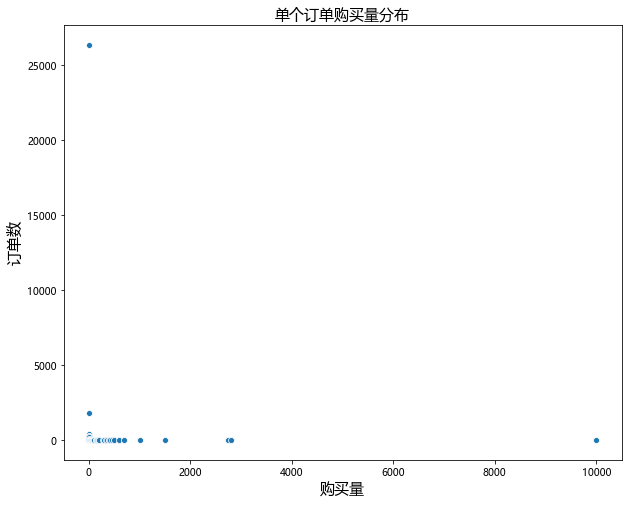

In [8]:
quantity = trade.buy_mount.value_counts().sort_index()
plt.figure(figsize=(10, 8))
sns.scatterplot(x=quantity.index, y=quantity.values, alpha=1)
plt.title("单个订单购买量分布", fontdict=fontdict)
plt.ylabel("订单数", fontdict=fontdict)
plt.xlabel("购买量", fontdict=fontdict)
plt.show()

### 数据清洗
1. 保留buy_amount[1,195]以内的订单。
2. 查看有无缺失值异常值，并进行处理。
3. trade中的auction_id未指定是什么属性，我们就将他默认改为item_id。
4. 数据集中的property全是数字，需要有对应的字典才能知道对应什么属性，这边先删除。
5. day改成日期形式。

In [9]:
# 保留buy_mount[0,195]以内的记录
trade = trade[(trade.buy_mount >= 1) & (trade.buy_mount <= 195)]
# 列重命名
trade.rename({"auction_id": "item_id"}, axis=1, inplace=True)
# 先将property暂且取出放在一边，后续再分析
property = trade.property
trade.drop('property', axis=1, inplace=True)
# 日期类型转换
baby['birthday'] = pd.to_datetime(baby.birthday.astype('str'))
trade['day'] = pd.to_datetime(trade.day.astype('str'))

In [10]:
# 本次统计数据的时间范围是2012/7/2-2015/2/5
trade.day.describe()

count                   29942
unique                    949
top       2014-11-11 00:00:00
freq                      454
first     2012-07-02 00:00:00
last      2015-02-05 00:00:00
Name: day, dtype: object

In [11]:
count_cat1 = trade.cat1.nunique()
count_cat = trade.cat_id.nunique()
count_item = trade.item_id.nunique()
sales_volume = trade.buy_mount.sum()
count_user = trade.user_id.nunique()
print("商品类目数：", count_cat1)
print("商品类别数：", count_cat)
print("商品数：", count_item)
print("总销量：", sales_volume)
print("用户数", count_user)

商品类目数： 6
商品类别数： 662
商品数： 28394
总销量： 49973
用户数 29915


## 数据分析

### 整体市场情况

In [12]:
# 根据年月查看销量趋势
# 根据年分组
year_item = trade[['item_id', 'buy_mount', 'day']].groupby(by=trade.day.dt.year)[
    'buy_mount'].sum()
# 各年季度销量情况
year_quarter_item = trade[['item_id', 'buy_mount', 'day']].groupby(by=[trade.day.dt.year, trade.day.dt.quarter])[
    'buy_mount'].sum()
# 根据年月分组
year_month_item = trade[['item_id', 'buy_mount', 'day']].groupby(
    by=[trade.day.dt.year, trade.day.dt.month])['buy_mount'].sum()

####    2012/7-2015/2期间总销量是49973件，从上图我们可以看出淘宝和天猫平台母婴商品市场销量整体呈现上升趋势，但是波动较大。

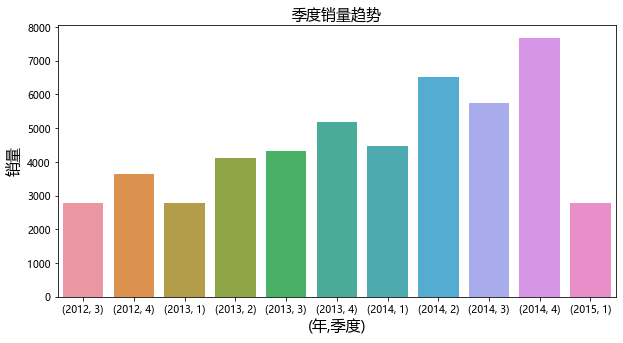

In [14]:
# 各季度销售情况
plt.figure(figsize=(10, 5))
sns.barplot(x=year_quarter_item.index, y=year_quarter_item.values)
plt.title("季度销量趋势", fontdict=fontdict)
plt.xlabel("(年,季度)", fontdict=fontdict)
plt.ylabel("销量", fontdict=fontdict)
plt.show()

1. 2015年由于数据缺失，所以不能反应2015年第一季度的真实销量情况
2. 每年第一季度的销售额都会呈现一定幅度的下跌。每年第四季度的销量都会呈现大幅度上升。

In [15]:
# 各月份销量情况
x = [str(x[0])+"/"+str(x[1]) for x in year_month_item.index]
y = [int(x) for x in year_month_item.values]
pyc.Bar().add_xaxis(xaxis_data=x
                    ).add_yaxis(series_name="销量", yaxis_data=y, markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(coord=[x[4], y[4]], value=y[4]), opts.MarkPointItem(coord=[x[10], y[10]], value=y[10]), opts.MarkPointItem(coord=[x[16], y[16]], value=y[16]), opts.MarkPointItem(coord=[x[22], y[22]], value=y[22]), opts.MarkPointItem(coord=[x[28], y[28]], value=y[28])])
                                ).set_series_opts(label_opts=opts.LabelOpts(is_show=False)
                                                  ).set_global_opts(title_opts=opts.TitleOpts(title="月销量趋势", subtitle="2012/7-2015/2的销量趋势图"), toolbox_opts=opts.ToolboxOpts()).render_notebook()

1. 2013年和2014年的第一季度销量都有所下滑，主要聚集在1、2月。
2. 每年的5月、11月都会出现不同程度的销量上涨。

#### 第一季度销量下滑原因
假设一下销售量下降是否和春节假期有关?\

In [18]:
def quarterData(trade: pd.DataFrame, low: tuple, high: tuple) -> list:
    """
    输入日期型字符串,返回日期范围内的销量和用户量
    """
    from datetime import datetime
    low = datetime.strptime(low, "%Y/%m/%d")
    high = datetime.strptime(high, "%Y/%m/%d")
    trade_low = trade[(trade.day >= datetime(low.year, low.month, low.day)) & (
        trade.day <= datetime(high.year, high.month, high.day))]
    group_low = trade_low[['buy_mount', 'day', 'user_id']].groupby(
        by=[trade_low.day.dt.month, trade_low.day.dt.day])
    mount = group_low.buy_mount.sum()
    user = group_low.user_id.nunique()

    return [mount, user]

In [19]:
def lineMountUser(mount, user, title):
    """
    输入销量和用户量数据以及标题，生成折线图
    """
    plot = pyc.Line().add_xaxis(xaxis_data=[str(x[0])+"/"+str(x[1]) for x in mount.index]
                                ).add_yaxis(series_name="销量", y_axis=[int(x) for x in mount.values], markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(name='当月销量均值', type_="average")])
                                            ).add_yaxis(series_name="用户量", y_axis=[int(x) for x in user.values], markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(name='当月用户量量均值', type_="average")])
                                                        ).set_series_opts(label_opts=opts.LabelOpts(is_show=False)
                                                                          ).set_global_opts(title_opts=opts.TitleOpts(title=title), toolbox_opts=opts.ToolboxOpts(), tooltip_opts=opts.TooltipOpts(trigger='axis')
                                                                                            ).render_notebook()
    return plot

In [20]:
mount_2013_1_quarter = quarterData(trade, "2013/1/1", "2013/3/31")[0]
mount_2014_1_quarter = quarterData(trade, "2014/1/1", "2014/3/31")[0]
user_2013_1_quarter = quarterData(trade, "2013/1/1", "2013/3/31")[1]
user_2014_1_quarter = quarterData(trade, "2014/1/1", "2014/3/31")[1]

In [21]:
lineMountUser(mount_2013_1_quarter, user_2013_1_quarter, "2013年第一季度销量")

In [22]:
lineMountUser(mount_2014_1_quarter, user_2014_1_quarter, "2014年第一季度销量")

- 2013/2/1-2013/2/15处于销量谷底，2013年春节假期：2013/2/9-2013/2/15
- 2014/1/26-2014/2/4处于销售谷底，2014年春节假期：2014/1/31-2014/2/6
> 2015年春节假期是2015/2/18-2015/2/24，数据集统计时间只到2015/2/5，所以就暂不分析2015年第一季度情况

临近春节可能存在部分企业提早放假，快递停运，销售低谷时段与春节假期基本吻合，假期结束后购买量和用户量上升，所以可以认为第一季度销量下降是由春节假期造成的

#### 第四季度销量上升原因
假设是否与双11双12活动有关？

In [23]:
mount_2012_4_quarter, user_2012_4_quarter = quarterData(
    trade, "2012/10/1", "2012/12/31")
mount_2013_4_quarter, user_2013_4_quarter = quarterData(
    trade, "2013/10/1", "2013/12/31")
mount_2014_4_quarter, user_2014_4_quarter = quarterData(
    trade, "2014/10/1", "2014/12/31")

In [24]:
lineMountUser(mount_2012_4_quarter, user_2012_4_quarter, "2012年第四季度销量")

In [25]:
lineMountUser(mount_2013_4_quarter, user_2013_4_quarter, "2013年第四季度销量")

In [26]:
lineMountUser(mount_2014_4_quarter, user_2014_4_quarter, "2014年第四季度销量")

1. 可以很明显看出2013年和2014年双十一及双十二当天的销量和销售额都激增。
2. 每年的双十一活动用户量和销量都比往年多，用户量增长为75%-80%。

#### 复购率

In [27]:
# trade = pd.merge(left=trade, right=baby, how='left',
#                       on='user_id', suffixes=("_trade", "_baby"))

In [28]:
# 由于数据不完整，所以我们只计算2013年和2014年的复购率
repurchase_data_2013 = trade[(trade.day >= datetime(
    2013, 1, 1)) & (trade.day <= datetime(2013, 12, 31))]
repurchase_data_2014 = trade[(trade.day >= datetime(
    2014, 1, 1)) & (trade.day <= datetime(2014, 12, 31))]

In [29]:
# 根据月和userid分组
group_2013 = repurchase_data_2013.groupby(
    by=[repurchase_data_2013.day.dt.month, 'user_id'])
group_2014 = repurchase_data_2014.groupby(
    by=[repurchase_data_2014.day.dt.month, 'user_id'])

In [30]:
def cmonthPurchaseRate(data):
    """
    导入根据月和userid分组数据
    """
    rate = []
    for i in range(1, 13):
        cmonth_bought_user = data.size()[[i, 'user_id']].sum()
        cmonth_repurchase_user = (data.size()[[i, 'user_id']] > 1).sum()
        rate.append(round(cmonth_repurchase_user/cmonth_bought_user, 4))
    return rate

In [31]:
purchase_rate_month_2013 = cmonthPurchaseRate(group_2013)
purchase_rate_month_2014 = cmonthPurchaseRate(group_2014)

In [32]:
pyc.Line().add_xaxis(xaxis_data=[x for x in range(1, 13)]
                     ).add_yaxis(
    series_name='2013年当月复购率', y_axis=purchase_rate_month_2013
).add_yaxis(series_name='2014年当月复购率', y_axis=purchase_rate_month_2014
            ).set_series_opts(label_opts=opts.LabelOpts(is_show=False)).set_global_opts(title_opts=opts.TitleOpts(title="当月复购率变化趋势", subtitle="2013年及2014年月复购率变化趋势"), toolbox_opts=opts.ToolboxOpts(), tooltip_opts=opts.TooltipOpts(is_show=True, trigger='axis')).render_notebook()

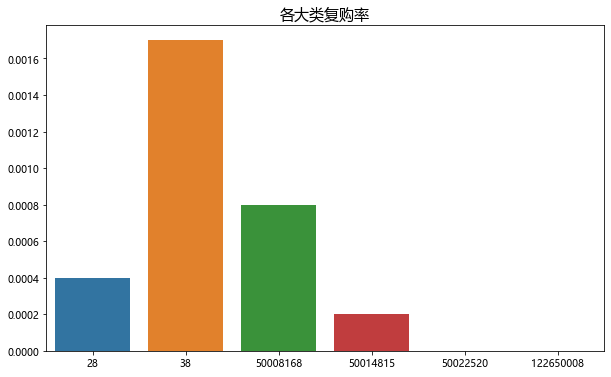

In [33]:
# 产品大类复购率
# 根据产品大类分组，然后循环大类进行索引求出每个大类的复购率
t = trade.groupby(by=['cat1', 'user_id']).size()
purchase_dict={}
for i in trade.cat1.unique():
    c = t.loc[i].value_counts()
    purchase_dict[i]=((c.sum()-c[:1])/c[:1]).values[0].round(4)
plt.figure(figsize=(10,6))
sns.barplot(x=list(purchase_dict.keys()),y=list(purchase_dict.values()))
plt.title("各大类复购率",fontdict=fontdict)
plt.show()

4月、10月及11月都存在一定的用户当月复购，但是复购率都极低，各产品大类的复购率也极低，均未到达1%，考虑到用户单次购买量大多是一件，且复购率低，说明用户对单一商品的回购欲望极低，商家应该从产品角度进行考虑，例如产品质量及购物体验等。

### 商品销售情况

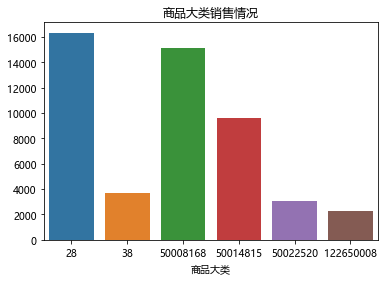

In [34]:
# 商品大类销售情况
cat = trade.groupby("cat1")['buy_mount'].sum()
sns.barplot(x=cat.index, y=cat.values)
plt.title("商品大类销售情况")
plt.xlabel("商品大类")
plt.show()

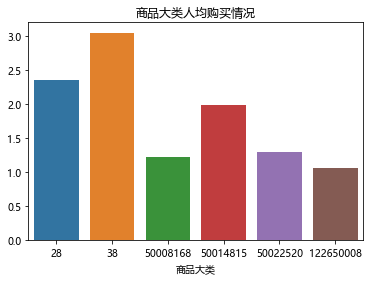

In [35]:
# 人均大类购买情况
cat_aver_user = (trade.groupby("cat1")['buy_mount'].sum(
) / trade.groupby("cat1")['user_id'].count()).sort_values(ascending=False)
sns.barplot(x=cat_aver_user.index, y=cat_aver_user.values)
plt.title("商品大类人均购买情况")
plt.xlabel("商品大类")
plt.show()

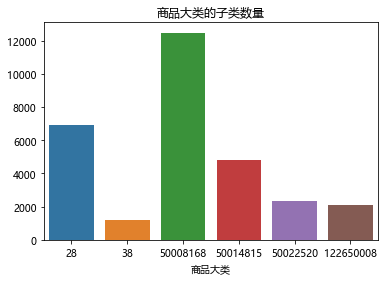

In [36]:
# 大类下子类别数量
cat_count = trade.groupby("cat1")['cat_id'].count()
sns.barplot(x=cat_count.index, y=cat_count.values)
plt.title("商品大类的子类数量")
plt.xlabel("商品大类")
plt.show()

大类28和50008168销量最佳，大类38虽然销量低、子类数最少但是人均购买量却很高，说明用户在购买38大类下的产品时选择余地较少，但同时用户对此类产品的需求又很旺盛，可以适量的增加38大类下的子类产品，提高销售量

### 婴儿情况

In [37]:
#trade_baby.groupby(by=trade_baby.birthday.dt.year).size()